In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model


- Apply Semi-Supervised Learning (SSL) to classify normal heartbeat and myocardial infarction from ECG signal. The dataset is from http://www.timeseriesclassification.com/description.php?Dataset=ECG200. The challenge of this dataset is that the training set contains only 100 observations, which is quite small for a supervised deep learning model to work well. So, **semi-supervised learning** is considered to learn features by Autoencoder (*Unsupervised learning*). After that, the encoder part (with pre-trained weights) of the autoencoder is used to build a predictive model (*Supervised learning*).


- Since the dataset is time-series, I decide to build a *Bidirectianal LSTM Autoencoder*. 


In [2]:
train_df = pd.read_csv('ECG200_TRAIN.txt', header=None, delim_whitespace=True)
test_df = pd.read_csv('ECG200_TEST.txt', header=None, delim_whitespace=True)

In [3]:
print(f'Train Shape: {train_df.shape}')
print(f'Test Shape: {test_df.shape}')
train_df.head()

Train Shape: (100, 97)
Test Shape: (100, 97)


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760140,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


## 1. Data Analysis and Transformation

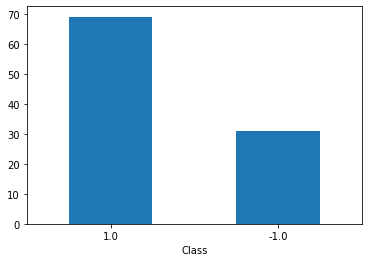

 1.0    69
-1.0    31
Name: 0, dtype: int64


In [4]:
train_df[0].value_counts().plot.bar(rot=360)
plt.xlabel('Class')
plt.show()
print(train_df[0].value_counts())

#  1: Normal
# -1: Infarction

In [5]:
X_train = train_df.drop(columns=0).values
y_train = train_df[0].values
X_test = test_df.drop(columns=0).values
y_test = test_df[0].values

# Class for y
encode_label = LabelEncoder()
encode_label.fit(y_train)
y_train = encode_label.transform(y_train)
y_test = encode_label.transform(y_test)

In [94]:
def plot_normal_ECG(normal_idx_list):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for i, idx in enumerate(normal_idx_list):
        ax[i].plot(range(len(X_train[normal_idx_list[i]])), X_train[normal_idx_list[i]])
        ax[i].set_title(f'Normal ECG')
        ax[i].grid()
    plt.show()

In [97]:
def plot_abnormal_ECG(abnormal_idx_list):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for i, idx in enumerate(abnormal_idx_list):
        ax[i].plot(range(len(X_train[abnormal_idx_list[i]])), X_train[abnormal_idx_list[i]])
        ax[i].set_title(f'Myocardial Infarction ECG')
        ax[i].grid()
    plt.show()

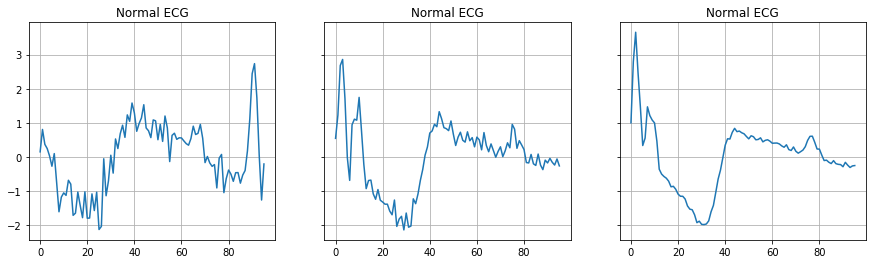

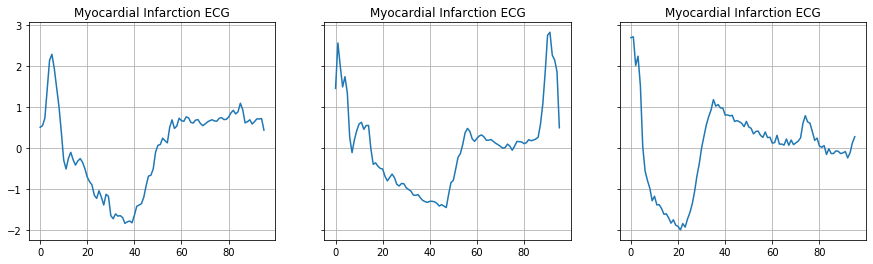

In [99]:
plot_normal_ECG([1, 71, 37])
plot_abnormal_ECG([0, 47, 96])

In [12]:
def plot_ECG(normal_idx, abnormal_idx):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    ax[0].plot(range(len(X_train[normal_idx])), X_train[normal_idx])
    ax[0].set_title(f'Normal ECG')
    ax[0].grid()
    ax[1].plot(range(len(X_train[abnormal_idx])), X_train[abnormal_idx])
    ax[1].set_title(f'Myocardial Infarction ECG')
    ax[1].grid()
    plt.show()

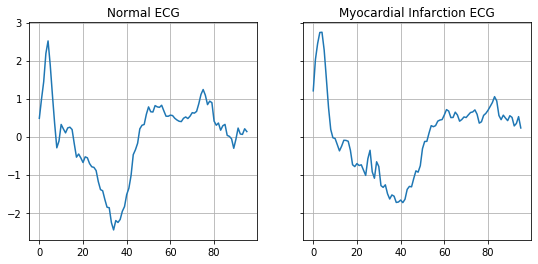

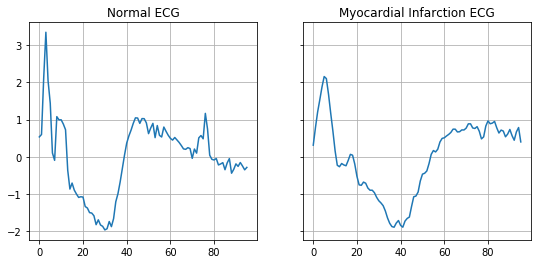

In [13]:
normal_idx = np.where(y_train==1)[0][5]
abnormal_idx = np.where(y_train==0)[0][3]
plot_ECG(normal_idx, abnormal_idx)
normal_idx = np.where(y_train==1)[0][32]
abnormal_idx = np.where(y_train==0)[0][11]
plot_ECG(normal_idx, abnormal_idx)

As we see in the above figures, it is not very easy for human to differentiate the types of ECG signals

In [6]:
# reshape X so that it can pass through LSTM layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## 2.1 Bidirectianal LSTM Autoencoder

In [15]:
class LSTMEncoderDecoder(keras.models.Model):
    def __init__(self):
        super(LSTMEncoderDecoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, input_shape=[96,1]), name='Bi-LSTM1'),
            layers.Bidirectional(layers.LSTM(32, dropout=0.2), name='Bi-LSTM2')])
        
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(96, input_shape=[64]),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2), name='Bi-LSTM3'),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2), name='Bi-LSTM4'),
            layers.TimeDistributed(layers.Dense(1))])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
def plot_history(history, loss=True, validation=False):
    if loss:
        plt.plot(history.history["loss"], label="Training Loss")
        if validation:
            plt.plot(history.history["val_loss"], label="Validation Loss") 
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
    else:
        plt.plot(history.history["accuracy"], label="Training Accuracy")
        if validation:
            plt.plot(history.history["val_accuracy"], label="Validation Accuracy") 
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()

In [17]:
autoencoder = LSTMEncoderDecoder()
autoencoder.compile(optimizer='adam', loss='mse')

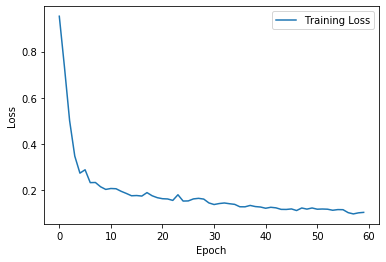

In [18]:
history = autoencoder.fit(X_train, X_train, epochs=60, batch_size=8, verbose=0) # validation_split=0.15, shuffle=True
plot_history(history, loss=True, validation=False)

In [19]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bi-LSTM1 (Bidirectional)     (None, 96, 128)           33792     
_________________________________________________________________
Bi-LSTM2 (Bidirectional)     (None, 64)                41216     
Total params: 75,008
Trainable params: 75,008
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 96, 64)            0         
_________________________________________________________________
Bi-LSTM3 (Bidirectional)     (None, 96, 64)            24832     
_________________________________________________________________
Bi-LSTM4 (Bidirectional)     (None, 96, 128)           66048     
______________________________

## 2.2 Predictive Deep Learning Model

Now we use the encoder part of our autoencoder to supervised classification model

In [45]:
x = autoencoder.encoder.output
x = layers.Dense(1, activation='sigmoid')(x)
predictive_model = keras.Model(autoencoder.encoder.input, x)

In [21]:
predictive_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bi-LSTM1_input (InputLayer)  [(None, 96, 1)]           0         
_________________________________________________________________
Bi-LSTM1 (Bidirectional)     (None, 96, 128)           33792     
_________________________________________________________________
Bi-LSTM2 (Bidirectional)     (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 75,073
Trainable params: 75,073
Non-trainable params: 0
_________________________________________________________________


In [70]:
x = autoencoder.encoder.output
x = layers.Dense(1, activation='sigmoid')(x)
predictive_model = keras.Model(autoencoder.encoder.input, x)

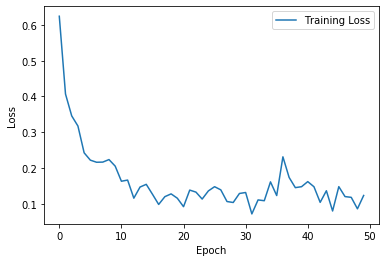

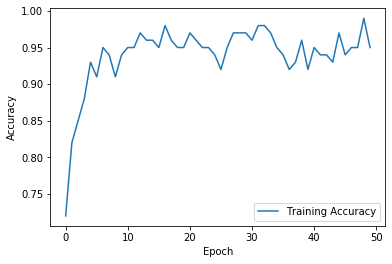

In [71]:
predictive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model_history = predictive_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)
plot_history(model_history, loss=True, validation=False)
plot_history(model_history, loss=False, validation=False)

In [74]:
predictive_model.save('semi_supervised_lstm.h5')

### 2.2.1. Evaluation

In [81]:
pred_test = predictive_model.predict(X_test)
pred_test = np.where(pred_test > 0.5, 1,0).reshape(-1,)
print(f'Test Accuracy: {accuracy_score(y_test, pred_test)*100}%')
print(f'Test F1 Score: {f1_score(y_test, pred_test)*100:.1f}%')

Test Accuracy: 91.0%
Test F1 Score: 93.2%


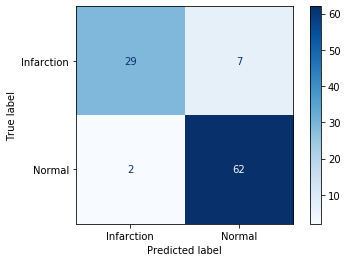

In [73]:
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Infarction", "Normal"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [75]:
print(classification_report(y_test, pred_test, target_names=["Infarction", "Normal"]))

              precision    recall  f1-score   support

  Infarction       0.94      0.81      0.87        36
      Normal       0.90      0.97      0.93        64

    accuracy                           0.91       100
   macro avg       0.92      0.89      0.90       100
weighted avg       0.91      0.91      0.91       100



It is interesting that we get **higher accuracy** than the best accuracy on this dataset (shown in the website: http://www.timeseriesclassification.com/description.php?Dataset=ECG200). My semi-supervised model got **91.0%** on the testing set.

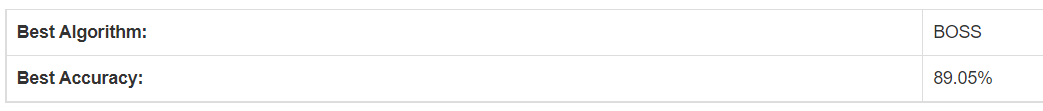

Besides the model accuracy, when looking at the recall score for infarction, it is just about 81%, which means that the model can still have a high chance of diagnosing infarction heartbeat as normal, which is a serious issue to avoid in practice.  
Anyway, the objective of this notebook is to show off the usage of semi-supervised learning to improve the performance of predictive models, especially when dealing with a small dataset. 

## (Optional) Using Supervised LSTM

Now Let us consider the supervised model performance alone without learning about features by autoencoder.

In [86]:
def Supervised_model():
    model = keras.Sequential(name='Supervised_LSTM')
    model.add(keras.layers.InputLayer(input_shape=(96, 1), name='Input'))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2), name='Bi-LSTM1'))
    model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.2), name='Bi-LSTM2'))
    model.add(layers.Dense(1, activation='sigmoid', name='Output'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

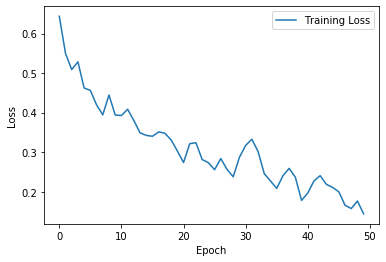

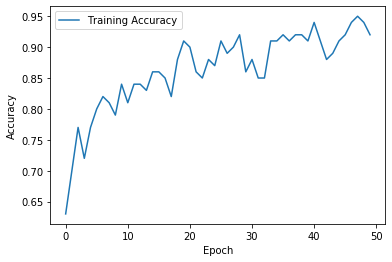

In [87]:
model = Supervised_model()
history = model.fit(X_train, y_train, batch_size=8, epochs=50, verbose=0)
plot_history(history, loss=True, validation=False)
plot_history(history, loss=False, validation=False)

In [88]:
pred_test = model.predict(X_test)
pred_test = np.where(pred_test > 0.5, 1,0).reshape(-1,)
print(f'Test Accuracy: {accuracy_score(y_test, pred_test)*100}%')
print(f'Test F1 Score: {f1_score(y_test, pred_test)*100:.1f}%')

Test Accuracy: 82.0%
Test F1 Score: 86.6%


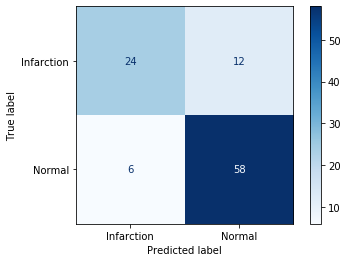

In [89]:
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Infarction", "Normal"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In this case we see that the model performance is just about 82% while semi-supervised learning can improve the accuracy of the same model architecture to 91% (by about 10% improvement)

## 2.3 Predictive Machine Learning Model

Since we have a quite a few training samples, we will also try traditional machine learning model such as Random forest. Still, we will use the latent dimension as an input for classifier. 

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold

In [8]:
model = load_model('semi_supervised_lstm.h5')
latent_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)

In [9]:
encoded_train = latent_model.predict(X_train)
encoded_test = latent_model.predict(X_test)

- using 5 fold nested cross-validation to find optimal parameters and evaluate the model.

In [10]:
model = RandomForestClassifier(random_state=0)

parameters = {'n_estimators':[10, 50, 100],
             'max_features':['sqrt']}

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

clf = GridSearchCV(model, parameters, n_jobs=-1, cv=cv_inner, refit=True)
clf.fit(encoded_train,y_train)
print('Selected parameters')
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, clf.best_params_[param_name]))   

# execute the nested cross-validation
acc_scores = cross_val_score(clf, encoded_train,y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Nested 5-fold Cross-validation')
print('Accuracy: %.3f (%.3f)' % (np.mean(acc_scores), np.std(acc_scores)))

Selected parameters
max_features: 'sqrt'
n_estimators: 50
Nested 5-fold Cross-validation
Accuracy: 0.950 (0.032)


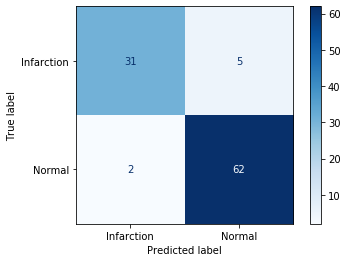

In [12]:
y_pred = clf.predict(encoded_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Infarction", "Normal"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
print(classification_report(y_test, y_pred, target_names=["Infarction", "Normal"]))

              precision    recall  f1-score   support

  Infarction       0.94      0.86      0.90        36
      Normal       0.93      0.97      0.95        64

    accuracy                           0.93       100
   macro avg       0.93      0.91      0.92       100
weighted avg       0.93      0.93      0.93       100



In [15]:
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)*100}%')
print(f'Test F1 Score: {f1_score(y_test, y_pred)*100:.1f}%')

Test Accuracy: 93.0%
Test F1 Score: 94.7%


The accuracy (**93.0%**) is improved comparing to the Autoencoder + Neural Network! Also, we can see that the k-fold accuracy and the test accuracy are not much different. This also implies that our model is not overfitting!

Now Let see if we the Random Forest performance without using autoencoder

In [26]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

model = RandomForestClassifier(random_state=0)

parameters = {'n_estimators':[10, 50, 100],
             'max_features':['sqrt']}

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

clf = GridSearchCV(model, parameters, n_jobs=-1, cv=cv_inner, refit=True)
clf.fit(X_train,y_train)
print('Selected parameters')
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, clf.best_params_[param_name]))   

# execute the nested cross-validation
acc_scores = cross_val_score(clf, X_train,y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Nested 5-fold Cross-validation')
print('Accuracy: %.3f (%.3f)' % (np.mean(acc_scores), np.std(acc_scores)))

Selected parameters
max_features: 'sqrt'
n_estimators: 100
Nested 5-fold Cross-validation
Accuracy: 0.820 (0.112)


In [27]:
y_pred = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)*100}%')
print(f'Test F1 Score: {f1_score(y_test, y_pred)*100:.1f}%')

Test Accuracy: 83.0%
Test F1 Score: 87.0%


## Summary

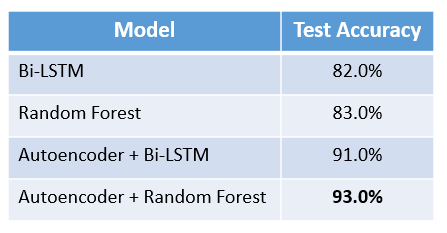

